# Random Forest

After reading (Liu, V. et al.) and (Mahmoud, M. et al.) I decided to begin expirementing with random forest models instead of logistic regression models.

In other studies, random forest models were shown to out perform logsitic regression and support vector models likely due to the mix of tabular, categorical, and numerical features

## Read and prep data for modeling

Feature exploration, cleaning, and feature engineering are handled in previous notebooks.

In [ ]:
%reload_ext autoreload
%autoreload 2
import sys, os
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

warnings.filterwarnings('ignore')
DATA_DIR = Path('../src/shared_util/data')

from shared_util.metrics import metrics_db
from shared_util.dataio import load_csv

METRICS_DIR = DATA_DIR / 'metrics'

LOG = True

if LOG:
    metrics_db.create_table(METRICS_DIR)

METRICS_DB_ID = 0 # update this to not overwrite previous metrics for these models
METRIC_NOTES = "None" # global metric notes for this run

In [ ]:
# df = pd.read_csv(f'{DATA_DIR}frame_no_interactions.csv', index_col=0)
# df.head()
df = load_csv('frame_no_interactions')
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag1_group_diabetes,diag1_group_digestive,diag1_group_genitourinary,diag1_group_injury,diag1_group_musculoskeletal,diag1_group_neoplasms,diag1_group_other,diag1_group_respiratory,diag2_group_circulatory,diag2_group_diabetes,diag2_group_digestive,diag2_group_genitourinary,diag2_group_injury,diag2_group_musculoskeletal,diag2_group_neoplasms,diag2_group_other,diag2_group_respiratory,diag3_group_circulatory,diag3_group_diabetes,diag3_group_digestive,diag3_group_genitourinary,diag3_group_injury,diag3_group_musculoskeletal,diag3_group_neoplasms,diag3_group_other,diag3_group_respiratory,admission_source_emergency,admission_source_refer,discharge_loc_left_ama,discharge_loc_outpatient_followup,discharge_loc_transfer_inpatient,discharge_loc_unknown,specialty_cat_cardiology,specialty_cat_internal_medicine,specialty_cat_other,specialty_cat_pcp,specialty_cat_surgery,race_cat_african_american,race_cat_other,age_group_<30,age_group_>60,gender_female,a1c_group_high,a1c_group_normal,glucose_group_high,glucose_group_normal,admit_type_group_elective,admit_type_group_na,admit_type_group_urgent,diabetesMed_flag,change_flag,metformin_flag,insulin_flag,num_drugs,target
0,1,41,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0
2,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,2,44,1,16,0,0,0,7,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
4,1,51,0,8,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,0


In [28]:
# split initial train and test sections

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, stratify=df['target'])

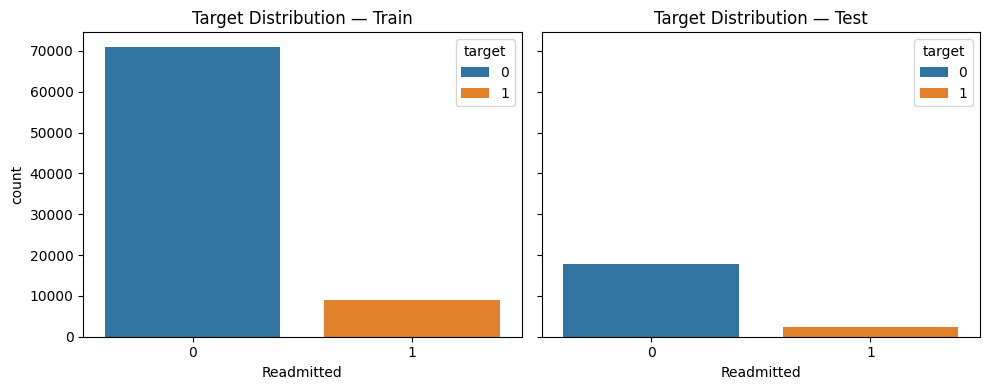

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fix, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
sns.countplot(x=y_train, ax=axes[0], hue=y_train)
axes[0].set_title('Target Distribution — Train')
axes[0].set_xlabel('Readmitted')
axes[0].set_ylabel('count')

sns.countplot(x=y_test, ax=axes[1], hue=y_test)
axes[1].set_title('Target Distribution — Test')
axes[1].set_xlabel('Readmitted')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()


Reusable stratified k-fold builder

Use 10 folds as per work from Liu, V.

10 folds remains computationaly simple while providing better bias of performance estimates over 5 folds



In [30]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def make_cv():
    return StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
    )

Get a baseline before looking at feature importance or hyperparameter tuning

We can use this baseline to check class imbalance approach methods, as well as to get a sense if this model can learn anything from the engineered features

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


cv = make_cv()

def get_baseline(sampling_tech) -> float:
    rf = RandomForestClassifier(random_state=42)

    pipe = Pipeline([
        ('under_sample', sampling_tech),
        ('model', rf)
    ])

    scores = cross_val_score(
        pipe, 
        X_train, 
        y_train, 
        cv = cv,
        scoring=make_scorer(roc_auc_score) 
        )

    print('roc_auc score per fold: ', scores)
    print('mean roc_auc score: ', scores.mean())
    return scores.mean()


print('Baseline ROC_AUC using Undersampling')

roc_auc_m = get_baseline(RandomUnderSampler(random_state=42))

if LOG:
    metrics_db.log_metric(
        metric_id=METRICS_DB_ID,
        model='rf_base_undsampl',
        pipeline_notes='under_sample',
        notes=METRIC_NOTES,
        roc_auc=roc_auc_m
    )



Baseline ROC_AUC using Undersampling
roc_auc score per fold:  [0.59996287 0.61050457 0.60508127 0.60141514 0.61472052 0.59462121
 0.59909583 0.60368674 0.61192741 0.62237717]
mean roc_auc score:  0.6063392724630032


,id,model,pipeline_notes,hyperparam_notes,notes,roc_auc,accuracy,precision,recall,f1,TN,TP,FP,FN
0,0,rf_base_undsampl,under_sample,None,None,0.606339,None,None,None,None,None,None,None,None


In [ ]:
from imblearn.over_sampling import SMOTE

print('Baseline ROC_AUC using SMOTE')

roc_auc_m = get_baseline(SMOTE(random_state=42))


if LOG:
    metrics_db.log_metric(
        metric_id=METRICS_DB_ID,
        model='rf_base_smote',
        pipeline_notes='SMOTE',
        notes=METRIC_NOTES,
        roc_auc=roc_auc_m
    )


Baseline ROC_AUC using SMOTE
roc_auc score per fold:  [0.5014859  0.50605401 0.5081704  0.50159996 0.50430661 0.50328535
 0.5034961  0.50432849 0.50242038 0.5066592 ]
mean roc_auc score:  0.504180640300917


,id,model,pipeline_notes,hyperparam_notes,notes,roc_auc,accuracy,precision,recall,f1,TN,TP,FP,FN
1,0,rf_base_smote,SMOTE,None,None,0.504181,None,None,None,None,None,None,None,None


The first run of random forest scores were abysmally poor running SMOTE:
 - mean roc_auc score:  0.5033108087188244

Swapping to RandomUnderSampler was somewhat better:
- mean roc_auc score:  0.5962262523855333

SMOTE performed much worse than under sampling so we will stick with under sampling going forward

A mean ROC_AUC score of 0.600 implies that the model has learned something from the data so we will continue analysis.

In [33]:
# shared code
import matplotlib.pyplot as plt


def make_rf_pipe():
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(random_state=42)
    return Pipeline(
        [
            ('under_sample', _u),
            ('model', _rf)
        ]
    )

def plot_feature_importance(df, col1, col2, size, title):
    plt.figure(figsize=(10,6))
    plt.barh(df[col1][:size][::-1], df[col2][:size][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



### Why prefer permutation importance here

- Tree impurity based importance is naturaly skewed to favor continuous features
- Permutation importance is model agnostic, is uneffected by the large class imbalance, and is not effected by the under sampling technique used

In [34]:
# Build cv for feature and perumation importance

from sklearn.inspection import permutation_importance


def cv_feature_importance(pipe_factory, X, y, cv):
    """
    Fit the pipeline returned by pipe_factory() on each CV train fold,
    collect model.feature_importances_ and return mean/std per feature.
    """
    imps = []
    for train_idx, val_idx in cv.split(X,y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        model = pipe.named_steps['model']
        imps.append(model.feature_importances_)
    imps = np.vstack(imps)
    df = pd.DataFrame({
        'feature' : X.columns,
        'importance_mean': imps.mean(axis=0),
        'importance_std' : imps.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df

def cv_permutation_importance(pipe_factory, X, y, cv, scoring='roc_auc', n_repeats=10, n_jobs=-1):
    """
    For each CV fold: fit on train, compute permutation_importance on validation.
    Aggregate mean/std across folds.
    """
    import numpy as np
    import pandas as pd

    perm_list = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        r = permutation_importance(pipe, X_val, y_val, scoring=scoring, n_repeats=n_repeats, n_jobs=n_jobs, random_state=42)
        perm_list.append(r.importances_mean) #type: ignore
    perm_arr = np.vstack(perm_list)
    df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': perm_arr.mean(axis=0),
        'importance_std': perm_arr.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df


### Feature Importance Using Random Forest Classifier

              feature  importance_mean  importance_std
1  num_lab_procedures         0.101976        0.000701
3     num_medications         0.090487        0.000394
0    time_in_hospital         0.067365        0.000970
6    number_inpatient         0.057847        0.000800
2      num_procedures         0.045914        0.000455


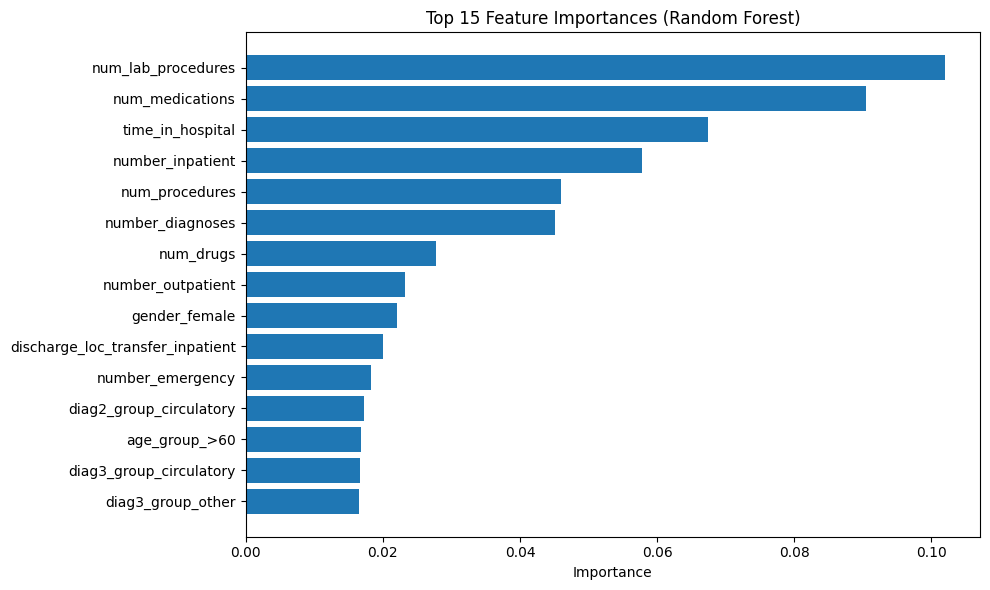

In [35]:
cv_rf = make_cv()

rf_imp_df = cv_feature_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_imp_df.head())
plot_feature_importance(rf_imp_df, 'feature', 'importance_mean', 15, "Top 15 Feature Importances (Random Forest)")

### Permutation Importance of Features

                             feature  importance_mean  importance_std
6                   number_inpatient         0.061554        0.005875
38  discharge_loc_transfer_inpatient         0.034298        0.004144
0                   time_in_hospital         0.005146        0.003332
3                    num_medications         0.005050        0.002715
5                   number_emergency         0.003387        0.001461
7                   number_diagnoses         0.002581        0.003391
48                     age_group_>60         0.002563        0.002366
1                 num_lab_procedures         0.001751        0.002784
14                 diag1_group_other         0.001708        0.001144
15           diag1_group_respiratory         0.001398        0.001681
50                    a1c_group_high         0.001247        0.000954
34        admission_source_emergency         0.001240        0.001442
4                  number_outpatient         0.001158        0.001947
12       diag1_group

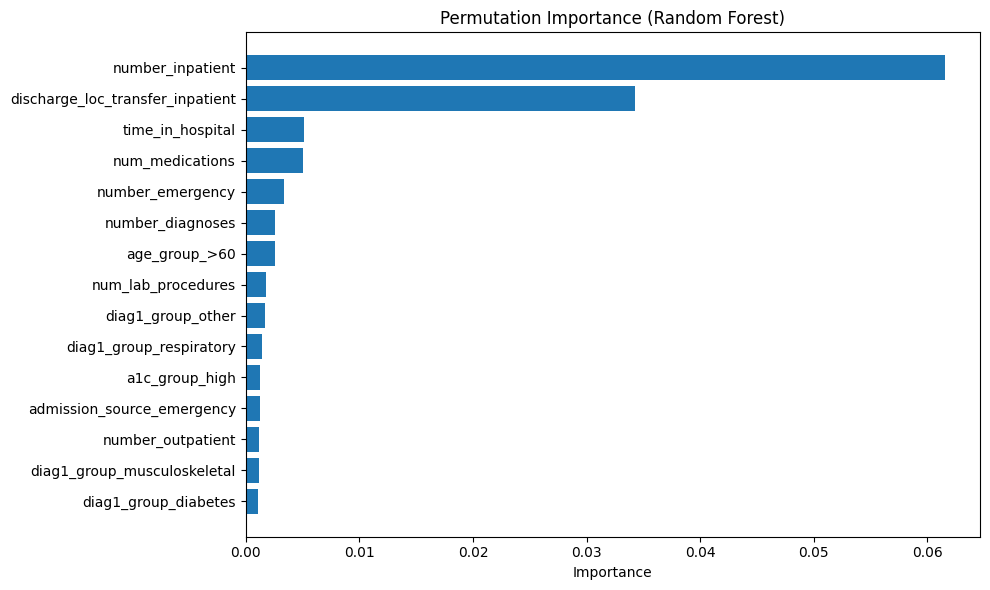

In [36]:
rf_perm_imp_df = cv_permutation_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_perm_imp_df.head(15))
plot_feature_importance(rf_perm_imp_df, 'feature', 'importance_mean', 15, 'Permutation Importance (Random Forest)')



Permutation importance reveals that the model is heavily leaning on the number of inpatient visits for its predictions.

Increased engineering of discharge_loc shows that transfer_inpatient is also now a leading factor

<HR>

### Comparison of feature importance with different data sets

The above section shows feature importance plots for the data set without interaction terms

below I'll add the interaction terms. These were generated using methodology explained in the Data Preperation notebook

In [ ]:
# get data with the interaction terms (linear data set)

df_int = load_csv('linear_frame')

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(df_int.drop(columns=['target']), df['target'], stratify=df['target'], random_state=42)


              feature  importance_mean  importance_std
1  num_lab_procedures         0.081802        0.000554
3     num_medications         0.072986        0.000532
6    number_inpatient         0.052608        0.001322
0    time_in_hospital         0.047365        0.000540
2      num_procedures         0.037714        0.000452


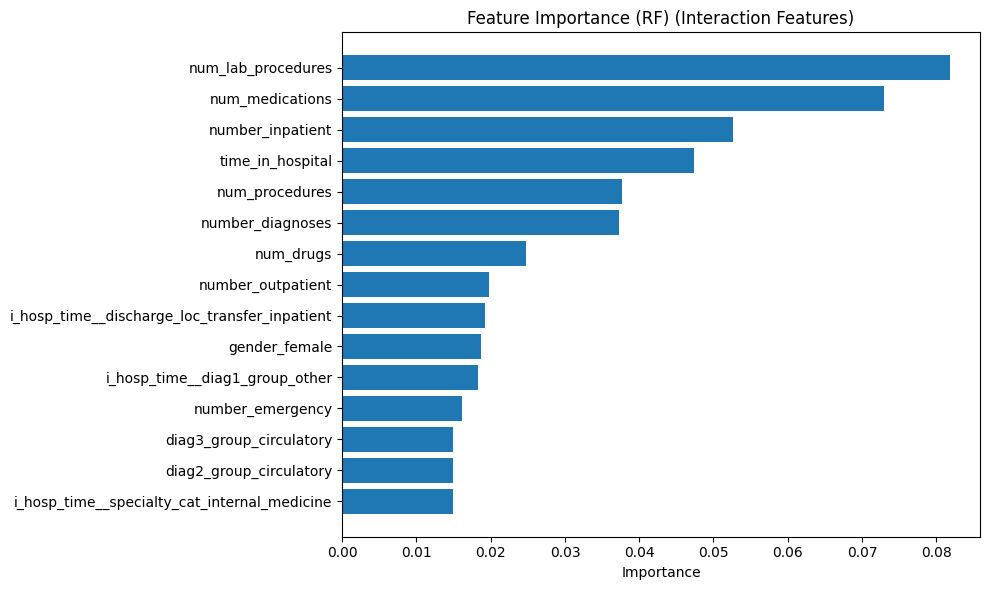

In [38]:
cv_rf_int = make_cv()

feat_imp_rf_int = cv_feature_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_imp_rf_int.head())
plot_feature_importance(feat_imp_rf_int, 'feature', 'importance_mean', 15, 'Feature Importance (RF) (Interaction Features)')

                                          feature  ...  importance_std
6                                number_inpatient  ...        0.008710
38               discharge_loc_transfer_inpatient  ...        0.002449
77  i_hosp_time__discharge_loc_transfer_inpatient  ...        0.002982
5                                number_emergency  ...        0.002312
3                                 num_medications  ...        0.003361

[5 rows x 3 columns]


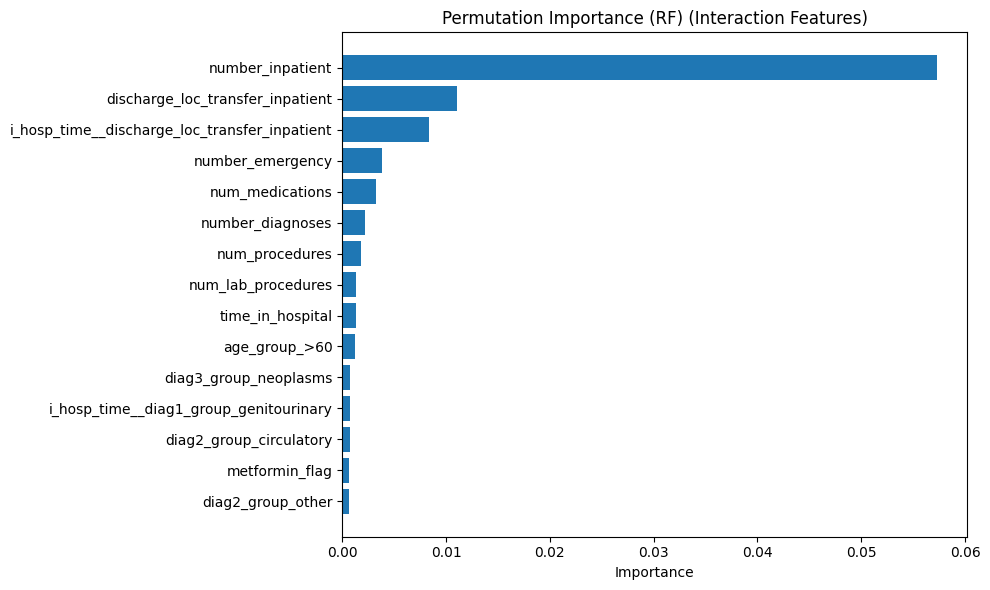

In [39]:
feat_perm_rt_int = cv_permutation_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_perm_rt_int.head())
plot_feature_importance(feat_perm_rt_int, 'feature', 'importance_mean', 15, 'Permutation Importance (RF) (Interaction Features)')

Analysis of feature importance aligns with previous literature and common sense thinking. The anaylsis suggests that the number of inpatient hospital visits in the patient's history is a leading factor in determining readmittance in the future.

Analysis also suggests discharges to other inpatient facilities is a strong indicator of readmittance risk.

The graph of Permutation Improtance for the with the interaction features shows that the discharge disposition X time in hospital interaction feature is a good indicator of readmittance risk, as stated in previous literature (Strack et al.)

Feature importance from the decision trees heavily favors continous features as expected, so we will use the permutation importance going forward.

<HR>

### Hyperparameter Search for Random Forest



In [40]:
from sklearn.model_selection import RandomizedSearchCV


pipe_h = make_rf_pipe()

param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'model__class_weight': [None, 'balanced'],
    'model__bootstrap': [True, False],
    'model__oob_score': [True, False]
}

rs = RandomizedSearchCV(
    estimator=pipe_h,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    cv=make_cv(),
    n_jobs=-1,
    random_state=42,
    refit=True
    )


rs.fit(X_train, y_train)

print("Best ROC_AUC (cv):", rs.best_score_)
print("Best params:", rs.best_params_)

# Summarize top results
res_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
res_df[['rank_test_score','mean_test_score','std_test_score','params']].head(10)

Best ROC_AUC (cv): 0.6631006942968429
Best params: {'model__oob_score': False, 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 0.2, 'model__max_depth': 10, 'model__class_weight': 'balanced', 'model__bootstrap': True}


,rank_test_score,mean_test_score,std_test_score,params
0,1,0.663101,0.009345,"{'model__oob_score': False, 'model__n_estimato..."
1,2,0.662953,0.009706,"{'model__oob_score': True, 'model__n_estimator..."
2,3,0.662826,0.009295,"{'model__oob_score': True, 'model__n_estimator..."
3,4,0.662661,0.009673,"{'model__oob_score': False, 'model__n_estimato..."
4,5,0.662218,0.009205,"{'model__oob_score': False, 'model__n_estimato..."
5,6,0.662137,0.009928,"{'model__oob_score': True, 'model__n_estimator..."
6,7,0.661955,0.008745,"{'model__oob_score': False, 'model__n_estimato..."
7,8,0.661813,0.009826,"{'model__oob_score': True, 'model__n_estimator..."
8,9,0.660989,0.009673,"{'model__oob_score': True, 'model__n_estimator..."
9,10,0.660897,0.009397,"{'model__oob_score': True, 'model__n_estimator..."


In [41]:
# predict on held out test set
y_proba = rs.best_estimator_.predict_proba(X_test)[:, 1] #type: ignore

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report
)

def print_metrics(y_true, 
                  y_pred,
                  y_proba, 
                  log=True, 
                  model=None,
                  pipeline_notes=None,
                  hyperparam_notes=None,
                  ):
    cnf = confusion_matrix(y_true, y_pred).ravel()
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    tn, fp, fn, tp = cnf[0], cnf[1], cnf[2], cnf[3]
    _roc_auc=float(roc_auc_score(y_true, y_proba))


    print(f"ROC_AUC:     {_roc_auc}")
    print("Accuracy:     ", acc)
    print("F1 score:     ", f1)
    print("Precision:    ", p)
    print("Recall:       ", r)
    print("\nConfusion matrix:\n")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print("\nClassification report:\n", classification_report(y_true, y_pred))

    if log:
        metrics_db.log_metric(
            metric_id=METRICS_DB_ID,
            notes=METRIC_NOTES,
            model=model or "",
            hyperparam_notes=hyperparam_notes or "",
            pipeline_notes=pipeline_notes or "",
            accuracy=float(acc),
            f1=float(f1),
            precision=float(p),
            recall=float(r),
            TN=tn,
            TP=tp,
            FN=fn,
            FP=fp,
            roc_auc=_roc_auc
            )

        


y_pred = rs.best_estimator_.predict(X_test) #type: ignore
# roc auc
print('Held Out Test Metrics (Random Forest)')
#print('ROC AUC:', roc_auc_score(y_test, y_proba))
print_metrics(y_test, y_pred, y_proba, 
              model='rf_held_out_test',
              hyperparam_notes="tuned_best_roc_auc",
              pipeline_notes='under_sample',
              log=LOG
              
)



Held Out Test Metrics (Random Forest)
ROC_AUC:     0.6586141595627101
Accuracy:      0.6225585693591088
F1 score:      0.2702337260961947
Precision:     0.1730793022392676
Recall:        0.6160281814178776

Confusion matrix:

TN: 11064, FP: 6684, FN: 872, TP: 1399

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.62      0.75     17748
           1       0.17      0.62      0.27      2271

    accuracy                           0.62     20019
   macro avg       0.55      0.62      0.51     20019
weighted avg       0.84      0.62      0.69     20019



<hr>

<HR>

The tuned random forest model initially displays decent class differentiation (ROC AUC = 0.65), but shows very poor Precision (0.16), and F1 (0.25) before threshold sweep.

The accuracy score is mostly meaningless due to high class imbalance.

The confusion matrix shows many false positives were predicted. 



Due to the nature of our business problem, we will align the model to attempt to maximize recall without sacrificing precision too much. This objective is due to the desire not to miss potential high risk patients while comparing the relatively low cost of having to spend extra time monitoring a patient who ends up without needing to be readmitted.

Best threshold (F2): 0.441
Precision: 0.153  Recall: 0.742  F2: 0.419


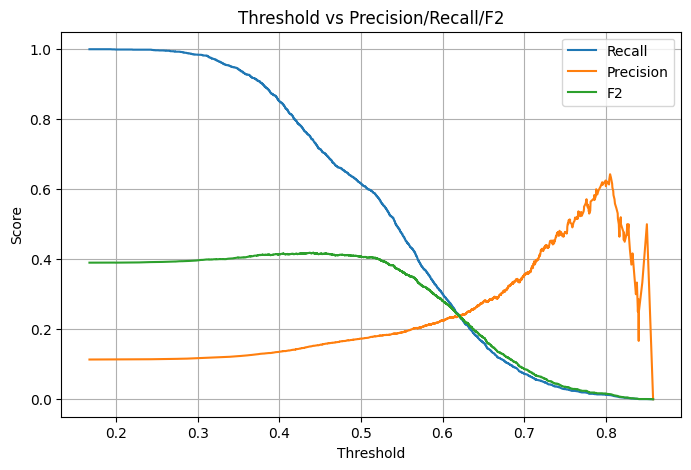

In [43]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# sweep thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# calculate F2 (recall-weighted) for each threshold
beta = 2
f2_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls + 1e-10)

# find threshold with best F2
best_idx = np.argmax(f2_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold (F{beta}): {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}  Recall: {recalls[best_idx]:.3f}  F{beta}: {f2_scores[best_idx]:.3f}")

# plot everything
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, f2_scores[:-1], label=f"F{beta}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall/F2")
plt.legend()
plt.grid(True)
plt.show()

y_pred_custom = (y_proba >= best_thresh).astype(int)




In [44]:
print_metrics(y_test, y_pred_custom, y_proba=y_proba,
              model='rf_f2_weighted',
              hyperparam_notes='tuned_best_roc_auc',
              pipeline_notes='under_sample'
              )

ROC_AUC:     0.6586141595627101
Accuracy:      0.503471701883211
F1 score:      0.2531930879038317
Precision:     0.15264063773892564
Recall:        0.7419638925583444

Confusion matrix:

TN: 8394, FP: 9354, FN: 586, TP: 1685

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.47      0.63     17748
           1       0.15      0.74      0.25      2271

    accuracy                           0.50     20019
   macro avg       0.54      0.61      0.44     20019
weighted avg       0.85      0.50      0.59     20019



By tuning the threshold we raised positive class recall to 0.76 while maintaining a 0.15 precision (low but almost unchanged from previous test)

In practice, this may be acceptable, likely it would depend on the increased monitoring costs for patients that are selected vs. costs saved on catching signs of required readmission earlier. 

The model has a very high rate of false positives which would require additional monitoring. However, the model has very few false negatives which means very few high-risk patients would be left un-monitored leading to the best patient outcomes at the cost of increased healthcare costs.

### Quick check of permutation importance after model tuning

                             feature  importance_mean  importance_std
6                   number_inpatient         0.077958        0.006137
38  discharge_loc_transfer_inpatient         0.040287        0.004748
7                   number_diagnoses         0.003454        0.001410
5                   number_emergency         0.003064        0.000875
0                   time_in_hospital         0.002259        0.001556
3                    num_medications         0.001925        0.000860
48                     age_group_>60         0.001624        0.000711
15           diag1_group_respiratory         0.001098        0.000758
1                 num_lab_procedures         0.001041        0.000826
61                         num_drugs         0.001002        0.000846
59                    metformin_flag         0.000878        0.000805
40          specialty_cat_cardiology         0.000867        0.000599
60                      insulin_flag         0.000656        0.000394
17              diag

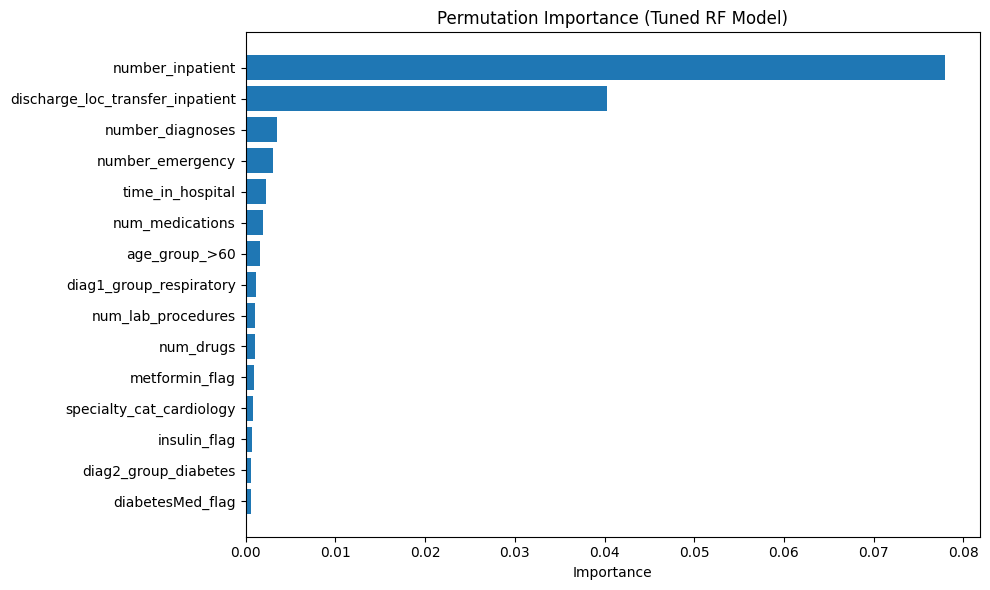

In [45]:
# recall: Best params: {'model__oob_score': True, 'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__class_weight': 'balanced', 'model__bootstrap': True}
# roc_auc: Best params: {'model__oob_score': True, 'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 0.2, 'model__max_depth': 10, 'model__class_weight': 'balanced', 'model__bootstrap': True}

def tuned_pipe_factory():
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=0.2,
        max_depth=10,
        class_weight='balanced', # redundant after using under sampling, but slightly improves metrics so it remains
        bootstrap=True,
        oob_score=True,
        random_state=42
        )
    return Pipeline(
        [
            ('under_sample', _u),
            ('model', _rf)
        ]
    )


rf_perm_imp_df = cv_permutation_importance(
    tuned_pipe_factory, 
    X_train, 
    y_train, 
    make_cv()
    )

print(rf_perm_imp_df.head(15))
plot_feature_importance(rf_perm_imp_df, 'feature', 'importance_mean', 15, 'Permutation Importance (Tuned RF Model)')